In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from parse_data import get_data, get_modified_values, get_binary_values, make_data_scalar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)



def make_data(df, device, seq_len):

    x_train, y_train = [], []
    prev = []
    m = df.max()[0]
    #print(df)
    for row in df.values:
        
        if len(prev) < seq_len:
            before = [0]*(seq_len - len(prev))
            for a in prev:
                before.append(a)
            #print(before)
            x_train.append(before)
        else:   
            x_train.append(prev[-seq_len:])
        y_train.append(row[0]/m)
        prev.append(row[0]/m)
    return x_train,y_train


def feature_engineering(X,Y):
    new_x, new_y = [], []
    
    for x, y in zip(X,Y):
        for i in range(5):
            curr_x = []
            for x_part in x:
                to_add = x_part + np.random.normal(loc=0, scale=0.01)
                if to_add > 1:
                    to_add = 1
                if to_add < 0:
                    to_add = 0
                curr_x.append(to_add)
            new_x.append(curr_x)
            new_y.append(y)
        #new_x.append(x)
        #new_y.append(y)
    return new_x, new_y

X, y = make_data(get_data(), None, 100)

X, y = feature_engineering(X,y)

print(X[0])

Using device:  cuda
[0.005541395874785101, 0, 0, 0, 0.01772366804301484, 0.008416788539712932, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0026257302282565935, 0, 0, 0, 2.4049813769203874e-05, 0.007004968967994774, 0.006261168574599915, 0.012851718514686373, 0, 0, 0.007171198880216869, 0.00045751680500234185, 0.004495885969306441, 0.0009010708947582261, 0, 0, 0, 0.01248164135535991, 0.0036611743393213277, 0, 0, 0.008564032280869598, 0.007505237271562868, 0, 0, 0, 0, 0.026279844588514498, 0, 0.009163717371394979, 0.0030356057425165147, 0.0010782175782379525, 0.011891482100105676, 0, 0, 0, 0.0027259268791214085, 0, 6.044869498236097e-05, 0, 0, 0.004753483395205954, 0, 0, 0.008960843831288857, 0.006827375023520214, 0, 0, 0.00863259166735258, 0, 0.005666859141140254, 0, 0.002280722165528493, 0, 0, 0, 0.00603089078421006, 0, 0, 0, 0.005842075478531239, 0, 0, 0.011916197693865337, 0, 0.008364396874889797, 0.0012623012567191932, 0, 0.008149118440781635, 0.0029207035820305277, 0, 0, 0, 0, 0, 0, 0.00187379

In [2]:
# gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb



model = xgb.XGBRegressor()
model.fit(X, y)
# make a single prediction
row = X[200:]
#print(row)
yhat = model.predict(X)
print('Prediction: %f' % yhat[65], "Actual: ", y[65])

correct = 0
count = 0
for y_val, yh in zip(y, yhat):
    count += 1 
    if yhat[0] == yh:
        correct += 1
print(correct, count)
    

Prediction: 0.082194 Actual:  0.06655574043261231
1 40760


In [3]:
def try_model(x,y, lr, estimators, max_depth, x_eval, y_eval, loss="squared_error"):
    model = xgb.XGBRegressor(learning_rate=lr, n_estimators=estimators, max_depth=max_depth, max_leaves=0, sampling_method="gradient_based")
    
    model.fit(x,y )
    
    return model

def model_score(model,x,y):
    yhat = model.predict(x)
    return mean_absolute_error(y,yhat)

learning_rate = [0.001, 0.01, 0.1, 0.005, 0.05]
max_depth = [ 50, 100]
estimators = [50, 100, 200, 500]


#learning_rate = [0.01]
#max_depth = [ 100]
#estimators = [50]
x_eval, y_eval = X, y = make_data(get_data(), None, 100)


best_m = None
best_loss = 10000000000000000000000
for lr in learning_rate:
    for depth in max_depth:
        for est in estimators:
            m = try_model(X,y, lr, est, depth,  x_eval, y_eval, loss="absolute_error",)
            loss = model_score(m,x_eval,y_eval)
            if loss < best_loss:
                print("New best model.\n\tNew loss:", loss, "\n\tOld loss:", best_loss)
                best_loss = loss
                best_m = m
                print(m.get_params())
            #else:
                #print("New model not better.\n\tNew loss:", loss, "\n\tOld loss:", best_loss)
             


New best model.
	New loss: 0.39468254876883885 
	Old loss: 10000000000000000000000
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.001, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 50, 'max_leaves': 0, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 50, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': 'gradient_based', 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
New best model.

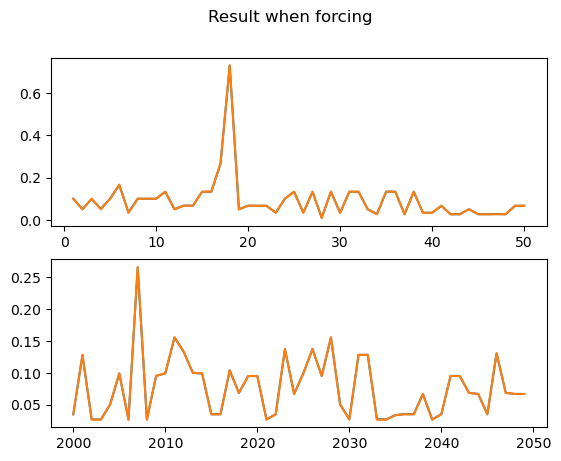

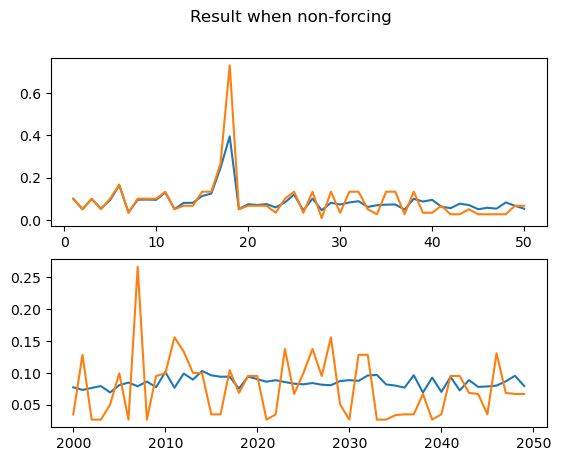

In [4]:
import matplotlib.pyplot as plt


def no_teacher_forcing(model, X, amount):
    curr_x = [0]*(len(X[0]))
    new_y = []
    
    for i in range(amount):
        y = model.predict([curr_x])
        curr_x.pop(0)
        curr_x.append(y[0])
        new_y.append(y)
    return new_y

def eval_model(y,yhat, name="forcing"):
   
    fig, ax = plt.subplots(2)
    
    ax[0].plot(range(1,51), yhat[:50])
    ax[0].plot( range(1,51), y[:50])

    ax[1].plot(range(2000,2050), yhat[2000:2050])
    
    ax[1].plot(range(2000,2050), y[2000:2050] )
    fig.suptitle("Result when %s" % name)
    fig.savefig("teacher_forcing.png")

    
X_corr, y_corr = make_data(get_data(), None, 100)

 
yhat = best_m.predict(X_corr)


eval_model(y_corr,yhat)

yhat = no_teacher_forcing(best_m, X_corr, len(y_corr))

eval_model(y_corr, yhat, name="non-forcing")